# Hyperparameter tuning

Na seção anterior, não discutimos os parâmetros de floresta aleatória e aumento de gradiente. No entanto, há algumas coisas que você deve ter em mente ao configurá-los.

Este bloco de notas fornece informações cruciais sobre como definir os hiperparâmetros dos modelos de árvore de decisão de aumento de gradiente e floresta aleatória.

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Caution!</p>
<p>Por motivos de clareza, nenhuma cross-validation será usada para estimar o erro de teste. Estamos apenas mostrando o efeito dos parâmetros no conjunto de validação do que deveria ser a cross-validation interna.</p>

### Random Forest

O parâmetro principal para ajustar para floresta aleatória é o parâmetro `n_estimators`. Em geral, quanto mais árvores na floresta, melhor será o desempenho de generalização. No entanto, isso diminuirá o tempo de adaptação e previsão. O objetivo é equilibrar o tempo de computação e o desempenho de generalização ao definir o número de estimadores ao colocar esse aluno em produção.

O parâmetro `max_depth` também pode ser ajustado. Às vezes, não há necessidade de árvores totalmente crescidas. No entanto, esteja ciente de que, com floresta aleatória, as árvores são geralmente profundas, pois estamos procurando ajustar os alunos nas amostras de bootstrap, pois isso será atenuado combinando-as. A montagem de árvores mal ajustadas (ou seja, árvores rasas) também pode levar a uma floresta mal ajustada.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

In [2]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "n_estimators": [10, 20, 30],
    "max_depth": [3, 5, None],
}
grid_search = GridSearchCV(
    RandomForestRegressor(n_jobs=2), param_grid=param_grid,
    scoring="neg_mean_absolute_error", n_jobs=2,
)
grid_search.fit(data_train, target_train)

columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_score", "rank_test_score"]
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results[columns].sort_values(by="rank_test_score")

,param_n_estimators,param_max_depth,mean_test_score,rank_test_score
8,30,None,34.491224,1
7,20,None,34.852569,2
6,10,None,35.997110,3
4,20,5,48.691969,4
5,30,5,48.719785,5
3,10,5,48.782024,6
2,30,3,56.941830,7
1,20,3,57.000582,8
0,10,3,57.337783,9


Podemos observar que em nossa pesquisa em grade, o maior `max_depth` junto com os maiores `n_estimators` levou ao melhor desempenho de generalização.

### Gradient-boosting decision trees

Para o aumento de gradiente, os parâmetros são acoplados, portanto, não podemos mais definir os parâmetros um após o outro. Os parâmetros importantes são `n_estimators`, `max_depth` e `learning_rate`.

Vamos primeiro discutir o parâmetro max_depth. Vimos na seção sobre aumento de gradiente que o algoritmo se ajusta ao erro da árvore anterior no conjunto. Assim, caber em árvores totalmente crescidas será prejudicial. Na verdade, a primeira árvore do conjunto se ajustaria perfeitamente (superadaptaria) aos dados e, portanto, nenhuma árvore subsequente seria necessária, uma vez que não haveria resíduos. Portanto, a árvore usada no aumento de gradiente deve ter uma profundidade baixa, normalmente entre 3 a 8 níveis. Ter alunos muito fracos em cada etapa ajudará a reduzir o sobreajuste.

Com essa consideração em mente, quanto mais profundas as árvores, mais rápido os resíduos serão corrigidos e menos alunos serão necessários. Portanto, `n_estimators` deve ser aumentado se `max_depth` for menor.

Finalmente, esquecemos o impacto do parâmetro `learning_rate` até agora. Ao ajustar os resíduos, gostaríamos que a árvore tentasse corrigir todos os erros possíveis ou apenas uma fração deles. A taxa de aprendizado permite que você controle esse comportamento. Um pequeno valor de taxa de aprendizagem corrige apenas os resíduos de muito poucas amostras. Se uma grande taxa de aprendizado for definida (por exemplo, 1), ajustaríamos os resíduos de todas as amostras. Portanto, com uma taxa de aprendizado muito baixa, precisaremos de mais estimadores para corrigir o erro geral. No entanto, uma taxa de aprendizagem muito grande tende a obter um conjunto superaquecido, semelhante a uma árvore com uma profundidade muito grande.

In [3]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    "n_estimators": [10, 30, 50],
    "max_depth": [3, 5, None],
    "learning_rate": [0.1, 1],
}
grid_search = GridSearchCV(
    GradientBoostingRegressor(), param_grid=param_grid,
    scoring="neg_mean_absolute_error", n_jobs=2
)
grid_search.fit(data_train, target_train)

columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_score", "rank_test_score"]
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results[columns].sort_values(by="rank_test_score")

,param_n_estimators,param_max_depth,param_learning_rate,mean_test_score,rank_test_score
5,50,5,0.1,35.664653,1
11,50,3,1,36.703013,2
10,30,3,1,37.458088,3
13,30,5,1,39.056313,4
4,30,5,0.1,39.354899,5
12,10,5,1,39.450557,6
14,50,5,1,39.730580,7
2,50,3,0.1,40.602042,8
9,10,3,1,41.602175,9
7,30,None,0.1,45.588320,10


<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Caution!</p>
<p>Aqui, ajustamos os n_estimators, mas esteja ciente de que usar a parada antecipada como no exercício anterior será melhor.</p>

# 📝 Exercício M6.05

O objetivo do exercício é familiarizar-se com o aumento de gradiente do histograma no scikit-learn. Além disso, usaremos este modelo em uma estrutura de validação cruzada para inspecionar parâmetros internos encontrados por meio de pesquisa em grade.

Usaremos o conjunto de dados de habitação da Califórnia.

In [4]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

Primeiro, crie um regressor de aumento de gradiente de histograma. Você pode definir o número de árvores para ser grande e configurar o modelo para usar a parada antecipada.

In [5]:
# solution
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hist_gbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=0)

Usaremos uma pesquisa em grade para encontrar algum parâmetro ideal para este modelo. Nesta pesquisa em grade, você deve pesquisar os seguintes parâmetros:

* `max_depth: [3, 8]`;
* `max_leaf_nodes: [15, 31]`;
* `learning_rate: [0,1, 1]`.

Sinta-se à vontade para explorar o espaço com valores adicionais. Crie a pesquisa em grade fornecendo a instância de aumento de gradiente anterior como o modelo.

In [6]:
# solution
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth": [3, 8],
    "max_leaf_nodes": [15, 31],
    "learning_rate": [0.1, 1],
}

search = GridSearchCV(hist_gbdt, params)

Por fim, faremos nosso experimento por meio de validação cruzada. A este respeito, defina uma validação cruzada de 5 vezes. Além disso, certifique-se de embaralhar os dados. Posteriormente, use a função `sklearn.model_selection.cross_validate` para executar a validação cruzada. Você também deve definir `return_estimator = True`, para que possamos investigar o modelo interno treinado por meio de validação cruzada.

In [7]:
# solution
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)
results = cross_validate(
    search, data, target, cv=cv, return_estimator=True, n_jobs=2)

Agora que obtivemos os resultados da validação cruzada, imprima a pontuação média e o desvio padrão.

In [8]:
# solution
print(f"R2 score with cross-validation:\n"
      f"{results['test_score'].mean():.3f} +/- "
      f"{results['test_score'].std():.3f}")

R2 score with cross-validation:
0.839 +/- 0.006


Em seguida, inspecione a entrada do `estimator` dos resultados e verifique os melhores valores dos parâmetros. Além disso, verifique a quantidade de árvores utilizadas pelo modelo.

In [9]:
# solution
for estimator in results["estimator"]:
    print(estimator.best_params_)
    print(f"# trees: {estimator.best_estimator_.n_iter_}")

{'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 15}
# trees: 528
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 447
{'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 15}
# trees: 576
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 290
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 414


Inspecione os resultados do CV interno para cada estimador do CV externo. Agregue a pontuação média do teste para cada combinação de parâmetros e faça um gráfico de caixa dessas pontuações.

In [10]:
# solution
import pandas as pd

index_columns = [f"param_{name}" for name in params.keys()]
columns = index_columns + ["mean_test_score"]

inner_cv_results = []
for cv_idx, estimator in enumerate(results["estimator"]):
    search_cv_results = pd.DataFrame(estimator.cv_results_)
    search_cv_results = search_cv_results[columns].set_index(index_columns)
    search_cv_results = search_cv_results.rename(
        columns={"mean_test_score": f"CV {cv_idx}"})
    inner_cv_results.append(search_cv_results)
inner_cv_results = pd.concat(inner_cv_results, axis=1).T

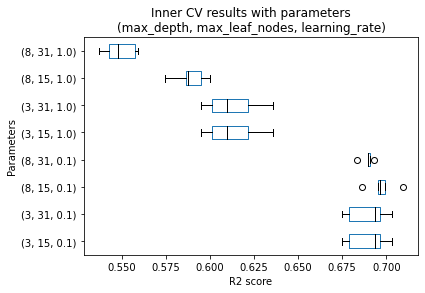

In [11]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel("R2 score")
plt.ylabel("Parameters")
_ = plt.title("Inner CV results with parameters\n"
              "(max_depth, max_leaf_nodes, learning_rate)")

Vemos que os primeiros 4 conjuntos de parâmetros classificados estão muito próximos. Podemos selecionar qualquer uma dessas 4 combinações. Ele coincide com os resultados que observamos ao inspecionar os melhores parâmetros do CV externo.